This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

This chapter focuses on forecasting, but there are also other types of tasks
with time series.

Classification - Assigning one or more categorical labels to a timeseries. For
instance, given the timeseries of the activity of a visitor on a website, classify
weather the visitor is a bot or a human.

Event Detection - Identify the occurrence of a specific event with a continous
data stream. Hot word detection is an example, like "Hey Google".

Anomoly Detection - Detect unusual happenings in the continous data stream.
Examples: unusual activity on a network, on equipment sensors, etc.

The fourier transform can be very valuable when processing data that is classified
by cycles and oscillations. Fourier analysis is very important in feature engineering.

## A temperature-forecasting example

In [22]:
#!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
#!unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [23]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [24]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # Store column 1 in the temperature array
    raw_data[i, :] = values[:] # All columns, including temperature, in raw_data

**Plotting the temperature timeseries**

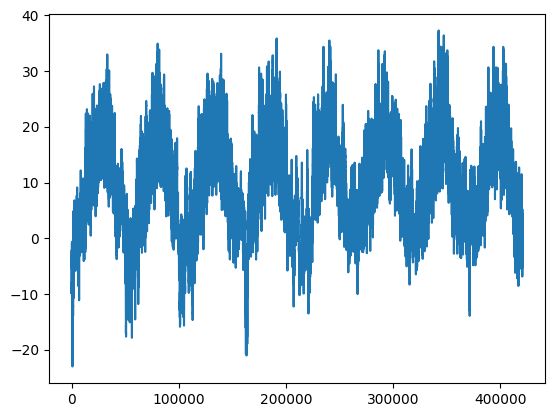

In [25]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

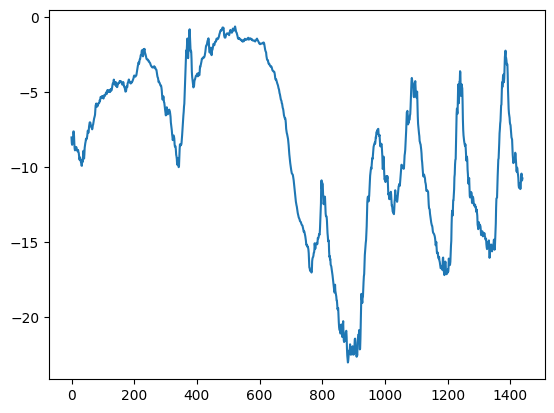

In [26]:
plt.plot(range(1440), temperature[:1440])

In all of the experiments we use the first 50% of the data for training, the
following 25% for validation, and the last 25% for testing.

**Computing the number of samples we'll use for each data split**

In [27]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

The data is already numerical so no encodeing is necessary. Each time series
is on a different scale. We normalize each to help in the optimization.

**Normalizing the data**

In [28]:
# Standardize all of the columns
display(raw_data.shape)
mean = raw_data[:num_train_samples].mean(axis=0)
display(mean)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

(420451, 14)

array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

In [29]:
# Here we use the dataset api to create batches
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10) # Generate an array of sorted integers from 0 to 9
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], # The sequences will be from [0 1 2 3 4 5 6]
    targets=int_sequence[3:], # the target for the sequence that starts at data[N] will be data [N+3]
    sequence_length=3, # Sequence length will be 3 steps long
    batch_size=2, # Batch size will be 2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [30]:
sampling_rate = 6 # Keep only 1 data point per hour
sequence_length = 120 # Observation will only go back 5 days
delay = sampling_rate * (sequence_length + 24 - 1) # The target will be the temp 24 hrs after the end of the sequence
batch_size = 256 # Samples in a batch

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

Each dataset yields a tuple (samples, targets), where samples is a batch of
256 samples, each with 120 consecutive hours of input data. Targets is the
corresponding array of 256 temperatures.

In [31]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

print('256 target temperatures, 256 Samples with 120 consecutive hours across 14 input variables')

samples shape: (256, 120, 14)
targets shape: (256,)
256 target temperatures, 256 Samples with 120 consecutive hours across 14 input variables


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

Naive forecast. Current temp equals the temp from 24 hours earlier.

In [32]:
# A seasonal naive approach
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-05-25 14:38:29.372745: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

We will use the MSE as the loss, rather than MAE, because
it is smooth around zero, which is useful for gradient descent

**Note**: The code provided does not work. 

This simple ML model does not work well. The common sense heuristic model is one among
millions. Just because a good solution exists, does not mean that you will always find 
it using gradient descent.

This is why feature engineering and good architecture matters.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

print(f'length: {sequence_length}, columns: {raw_data.shape[-1]}')

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model.summary()

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

print(train_dataset)

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

length: 120, columns: 14


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
Epoch 1/10


2025-05-25 14:55:02.244197: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1


InvalidArgumentError: Graph execution error:

Detected at node functional_6_1/flatten_6_1/Reshape defined at (most recent call last):
  File "/home/jonathan/miniforge3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/jonathan/miniforge3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/jonathan/miniforge3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/jonathan/miniforge3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/jonathan/miniforge3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_5756/3045366269.py", line 25, in <module>

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 4937, in reshape

  File "/home/jonathan/Projects/deep_learning_with_python/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 2024, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_6_1/flatten_6_1/Reshape}}]] [Op:__inference_multi_step_on_iterator_23087]

**Plotting results**

In [0]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

This one does even worse...

Order in the data matters so Convnets do not take advantage of this.

In [39]:
# Try a 1D convolutional model
print(f'length: {sequence_length}, columns: {raw_data.shape[-1]}')

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

length: 120, columns: 14
Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 32.8975 - mae: 4.3626 - val_loss: 16.2742 - val_mae: 3.1738
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 15.5227 - mae: 3.1312 - val_loss: 16.6287 - val_mae: 3.2497
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 13.8226 - mae: 2.9458 - val_loss: 13.4619 - val_mae: 2.8776
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 12.8072 - mae: 2.8288 - val_loss: 14.9809 - val_mae: 3.0533
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 12.1807 - mae: 2.7629 - val_loss: 14.2809 - val_mae: 2.9467
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.6341 - mae: 2.6987 - val_loss: 13.6046 - val_mae: 2.8784
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - loss: 11.2772 - mae: 2.6578 - val_loss: 14.2939 - val_mae: 2.9528
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 10.9755 - mae: 2.6210 - val_loss: 16.4999 - val_mae: 3.1890

### A first recurrent baseline

The densely connected approach first flattened the timeseries, which removed the notion of time 
from the input data. The convolutional approach treated every segment of the data in the same way, 
even applying pooling, which destroyed order information.

Here we try an LSTM

**A simple LSTM-based model**

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 79ms/step - loss: 75.1354 - mae: 6.5971 - val_loss: 12.4844 - val_mae: 2.6745
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 11.9687 - mae: 2.6675 - val_loss: 9.7026 - val_mae: 2.4205
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 9.9826 - mae: 2.4612 - val_loss: 9.5694 - val_mae: 2.3976
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 112ms/step - loss: 9.3639 - mae: 2.3798 - val_loss: 9.5012 - val_mae: 2.3981
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - loss: 8.8973 - mae: 2.3164 - val_loss: 9.5330 - val_mae: 2.3974
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 124ms/step - loss: 8.6352 - mae: 2.2816 - val_loss: 9.7411 - val_mae: 2.4334
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 186ms/step - loss: 8.4231 - mae: 2.2563 - val_loss: 9.9263 - val_mae: 2.4502
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 121s 87ms/step - loss: 8.2223 - mae: 2.2286 - val_loss: 9.9563 - val_mae: 2.4568
Epoch 9/10
819/819 ━━━━━━━━━━━━

## Understanding recurrent neural networks

With such networks, in order to process a sequence or a temporal series of data points, you have to 
show the entire sequence to the network at once: **turn it into a single data point**. For instance, 
this is what we did in the densely connected network example: we flattened our five days of data 
into a single large vector and processed it in one go. Such networks are called feedforward networks.

RNNs adopt the same principle, albeit in a simplified version. It processes a sequence of elements
maintaining a state that contains information relative to what it has seen so far. It has an internal
loop.

### Pseudocode for RNN

```python
state_t = 0                        # Initialize the state
for input_t in input_sequence:     # Iterate over a sequence
    output_t = f(input_t, state_t) # Calculate an output
    state_t = output_t             # Previous output becomes the state for the next iteration
```

The transformation will be parameterized by two matricies, $W$ an $U$ and a bias $b$.

```python
state_t = 0  
for input_t in input_sequence:     
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)     
    state_t = output_t
```
RNNs are characterized by their step functions:

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```
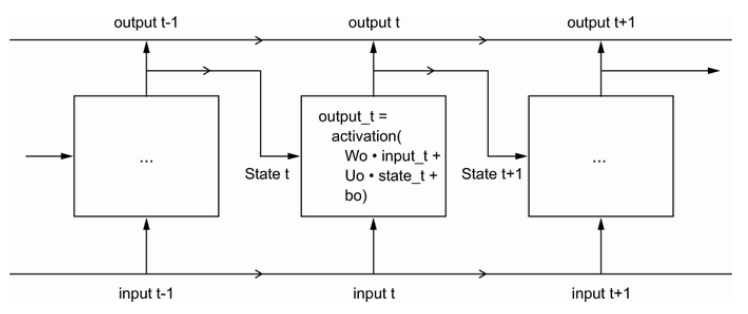


**NumPy implementation of a simple RNN**

In [41]:
import numpy as np

# Initialize everyting
timesteps = 100 # # of timesteps in the input sequence
input_features = 32 # Dimensionality of the input feature space
output_features = 64 # Dimensionality of the output feature space
inputs = np.random.random((timesteps, input_features)) # Input data
state_t = np.zeros((output_features,)) # Initial State
W = np.random.random((output_features, input_features)) # Initialize weight matricies
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []


for input_t in inputs: # input_t is the sampels in inputs data set
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # Calculate output of the step
    successive_outputs.append(output_t) # Store output
    state_t = output_t # Assign the output to the state for the next step
final_output_sequence = np.stack(successive_outputs, axis=0) # final output is a rank-2 tensor (timesteps, outputfeatures)

### A recurrent layer in Keras

The above process roughly corresponds to a `SimpleRNN` layer. The only difference
is that `SimpleRNN` processes batches. This means it takes inputs of shape
(batch_size, timesteps, input_features) Note that you can set the timesteps to
None to process sequences of arbitrary length.

However there are benefits to specifying the length as it enables `model.summary`

**An RNN layer that can process sequences of any length**

In [42]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

RNNs can be run it two modes. They can return only the last output, or return the
full sequences of outputs for each timstep. `return_sequences=False` is the default.
If you choose to stack RNN layers you will need the full sequences.

IN practice you will not use the `SimpleRNN` layer as it is too simplistic. It will
have a vanishing gradient problem. `LSTM` and `GRU` are layers designed to address
this.

In [43]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [44]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [45]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

### LSTM

This is a variant of the `SimpleRNN`. It adds a way to carry information across
many time steps. Data can jump into the state and get carried forward.

LSTM introduces a carry flow that carries information across time steps. It will
affect the state.

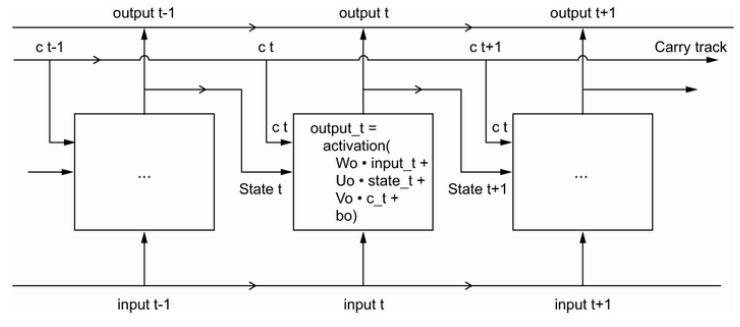

#### Pseudocode of LSTM
```python
# Calculate the new state
output_t = activation(dot(state_t, U0) + dot(input_t, W0) + dot(c_t, V0) + b0)

# Calculate the new carry forward
i_t = activation(dot(state_t, Ui) + dot (input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
c_t+1 = i_t*k_t*c_t*f_t
```

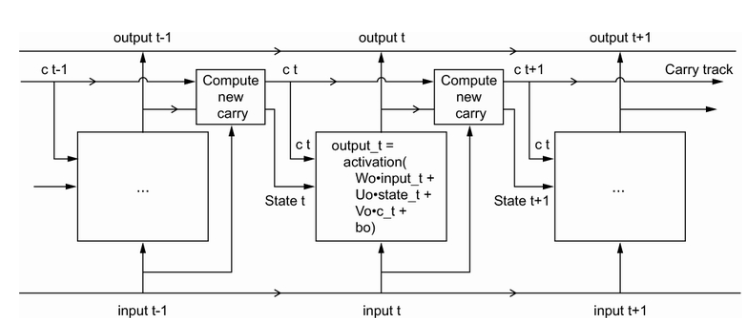

#### Anatomy of LSTM

`c_t * f_t` is a way do deliberately forget information
`i_t` and `k_t` provide information about the present updating the carry track.
However this is really the best that you can do.

The specification of the RNN cell determines the hypothesis space. The weights
determine what the cell does. 

## Advanced use of recurrent neural networks

We will learn 3 techniques:

- Recurrent dropout: This fights overfitting
- Stacking recurrent layers: increases representational power of the model
- Bidirectional recurrent layers: presents the same information in different
  ways to increase accuracy

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

- The same dropout mask should be applied at every step
- There should be a recurrent dropout mask
- Every recurrent layer in keras has two dropout arguments, `dropout` and `recurrent_dropout`.
- Dropout can serve for regularization instead of network size

> Note: To speed up your RNN layers when you can't use cuDNN, you can try
> unrolling it. Instead of using the for loops you can do the looping explicitly
> to optimize the computational graph.
>
> There is an option in the layer `unroll = True` to execute this

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 169s 199ms/step - loss: 48.8392 - mae: 5.1889 - val_loss: 9.4769 - val_mae: 2.3950
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 220ms/step - loss: 15.2932 - mae: 3.0434 - val_loss: 9.0922 - val_mae: 2.3526
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 185ms/step - loss: 14.4617 - mae: 2.9507 - val_loss: 9.0954 - val_mae: 2.3510
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - loss: 14.0341 - mae: 2.9066 - val_loss: 9.0193 - val_mae: 2.3396
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - loss: 13.4302 - mae: 2.8446 - val_loss: 8.9033 - val_mae: 2.3215
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 150s 183ms/step - loss: 13.1015 - mae: 2.8082 - val_loss: 8.8047 - val_mae: 2.3089
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 12.8312 - mae: 2.7829 - val_loss: 8.8893 - val_mae: 2.3154
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - loss: 12.6516 - mae: 2.7593 - val_loss: 8.8849 - val_mae: 2.3096
Epoch 9/50
819/8

In [0]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

It's generally a good idea to increase the capacity of your network until you
are able to overfit. You can then use regularization to manage the overfitting.

Increasing capacity is typically done by increasing the number of units in each
layer or adding layers.

You can stack recurrent layers, but you need to return full sequences (`return_sequences=True`).

**Training and evaluating a dropout-regularized, stacked GRU model**

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 205s 238ms/step - loss: 43.2196 - mae: 4.8807 - val_loss: 9.3229 - val_mae: 2.3536
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 218s 267ms/step - loss: 14.5028 - mae: 2.9544 - val_loss: 8.7384 - val_mae: 2.2958
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 219s 267ms/step - loss: 13.6025 - mae: 2.8558 - val_loss: 8.7158 - val_mae: 2.2927
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 220s 269ms/step - loss: 13.0871 - mae: 2.8038 - val_loss: 8.7275 - val_mae: 2.2963
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 271s 330ms/step - loss: 12.7891 - mae: 2.7696 - val_loss: 8.4469 - val_mae: 2.2553
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 297s 362ms/step - loss: 12.3982 - mae: 2.7340 - val_loss: 8.5974 - val_mae: 2.2762
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 293s 357ms/step - loss: 12.0861 - mae: 2.7002 - val_loss: 8.5818 - val_mae: 2.2729
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 199s 243ms/step - loss: 11.7450 - mae: 2.6641 - val_loss: 8.4476 - val_mae: 2.2530
Epoch 9/50
819/8

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

Bidirectional RNNs can offer greater performance for certain tasks. This is often
the case for NLP. A bidirectional RNN exploits order sensistivity. It uses two
regular RNNs, like `GRU` and `LSTM`, each processing the input sequence in one
direction (chronologically and antichronologically). This can catch patterns
that are not seen in the unidirectional case. Bidirectional RNNs can be thought
of as a variant of ensembling.

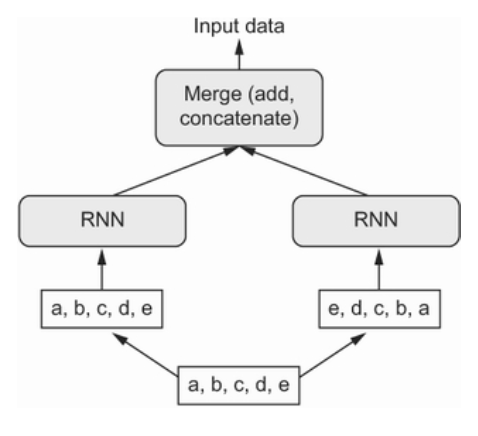

You will use a bidirectional layer that takes a recurrent layer as its first
argument. 

- Bidirectional work good on text data
- Not so good on time series as there is not much helpful information in the
  backward pass

#### Other forecasting improvements

- Adjust the units in each recurrent layer
- Adjust the learning rate
- Try using a stack of Dense layers as the regressor on the recurrent layer
  instead of a singe dense layer
- 

**Often improving the baseline by 10% is probably the best you can do for any
given problem.**



In [0]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary